In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
import tensorflow as tf

#Function import
from ipynb.fs.full.autoXRD import normdata
from ipynb.fs.full.autoXRD import normdatasingle
from ipynb.fs.full.autoXRD import augdata
from ipynb.fs.full.autoXRD import exp_augdata
from ipynb.fs.full.autoXRD import exp_data_processing

In [2]:
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
print(theor.shape)
theor = theor.iloc[1:,]
theor_arr = theor.values
print(theor_arr.shape)

exp = pd.read_csv('Datasets/exp.csv', index_col=0)
exp_arr = exp.values
print(exp_arr.shape)

(2402, 1468)
(2401, 1468)
(4305, 136)


In [3]:
label_theo = pd.read_csv('Datasets/label_theo.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

# Load experimental class labels
label_exp= pd.read_csv('Datasets/label_theo.csv', index_col=0).values
label_exp = label_exp.reshape([len(label_exp),])

space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

(2401, 1468)
(4305, 136)
(2401, 734)
(4305, 68)


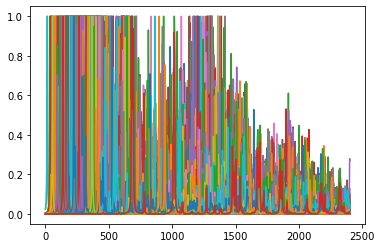

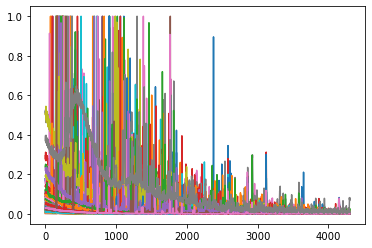

(734,)
(734, 2401)
(734,)
(68, 2000)
(68,)


In [47]:
# Normalize data for training
ntheor = normdata(theor_arr)
# Normalize experimental data
nexp = normdata(exp_arr)

#avant
print(theor_arr.shape)
print(exp_arr.shape)
#apres
print(ntheor.shape)
print(nexp.shape)

plt.plot(ntheor)
plt.show()

plt.plot(nexp)
plt.show()

#Ici label_theo toujours pas bon
# Define spectral range for data augmentation
exp_min = 0
exp_max = 1400 
theor_min = 125

#window size for experimental data extraction
window = 20
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing (nexp, exp_min, exp_max, window))

# Specify how many data points we augmented
th_num = 734

# Augment data, this may take a bit
augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)

# Enconde theoretical labels
label_t=np.zeros([len(pard),])
for i in range(len(pard)):
    label_t[i]=space_group_enc.index(pard[i])
    
print(label_t.shape)

#prepare X et Y
X_th = np.transpose(ntheor)
Y_th = label_t

print(X_th.shape)
print(Y_th.shape)

# Input the num of experimetal data points       
exp_num = 68

# Prepare experimental arrays for training and testing
X_exp = np.transpose(post_exp[:,0:exp_num])
Y_exp = label_exp[0:exp_num]

print(X_exp.shape)
print(Y_exp.shape)

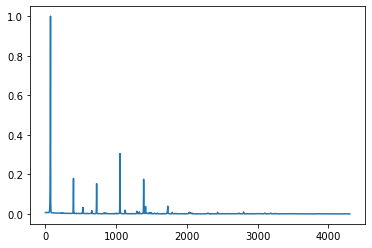

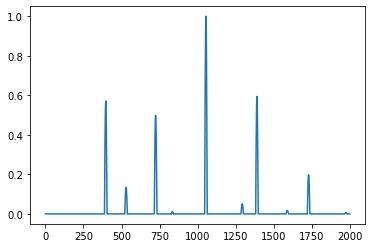

In [52]:
plt.plot(nexp[:,1])
plt.show()
plt.plot(X_exp[1,:])
plt.show()

(734, 2401, 1)
(68, 2000, 1)


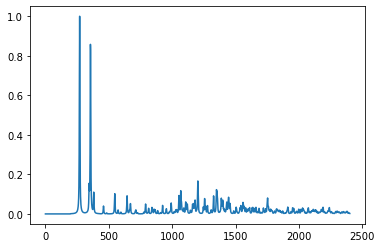

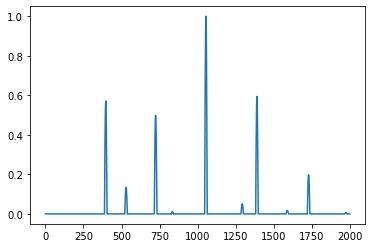

In [50]:
X_th = X_th.reshape(734, 2401, 1)
print(X_th.shape)
X_exp = X_exp.reshape(68, 2000, 1)
print(X_exp.shape)

plt.plot(X_th[1,:,:])
plt.show()
plt.plot(X_exp[1,:,:])
plt.show()

In [15]:
# Introduction de set de test à partir de la base de données
from sklearn.model_selection import train_test_split
# Definition du set de test 20% d'images random
# Avec cette ligne on definit set de images et targets pour l'entrainement et test
X_th_train, X_th_valid, Y_th_train, Y_th_valid = train_test_split(X_th, Y_th, test_size=0.2, random_state=1)

print(X_th_train.shape)
print(X_th_valid.shape)

train_dataset = tf.data.Dataset.from_tensor_slices(X_th)
valid_dataset = tf.data.Dataset.from_tensor_slices(X_th_valid)

print(train_dataset)
print(valid_dataset)

(587, 2401, 1)
(147, 2401, 1)
<TensorSliceDataset shapes: (2401, 1), types: tf.float64>
<TensorSliceDataset shapes: (2401, 1), types: tf.float64>


In [16]:
for item in train_dataset:
    print(item.shape)
    break

(2401, 1)


In [17]:
epoch = 1
batch_size = 32
for batch_training in train_dataset.repeat(epoch).batch(32):
    print(batch_training.shape)
    break

(32, 2401, 1)


In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_th, Y_th))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_th_valid, Y_th_valid))

NameError: name 'X_th' is not defined

In [19]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for X_th_batch, Y_th_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(X_th_batch.shape, Y_th_batch.shape)
    break

(32, 2401, 1) (32,)


In [21]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv1D(32, 8, activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv1D(64, 3, activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv1D(128, 3, activation='relu', name="conv3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(4, activation='softmax', name="output")

    def call(self, X_th):
        conv1 = self.conv1(X_th)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        flatten = self.flatten(conv3)
        d1 = self.d1(flatten)
        output = self.out(d1)
        return output

model = ConvModel()

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [23]:
# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [24]:
@tf.function
def train_step(X_th, Y_th):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(X_th)
        # Get the error/loss on these predictions
        loss = loss_object(Y_th, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(Y_th, predictions)

In [25]:
@tf.function
def valid_step(X_th, Y_th):
    predictions = model(X_th)
    t_loss = loss_object(Y_th, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(Y_th, predictions)

In [26]:
epoch = 10
batch_size = 128
b = 0
for epoch in range(epoch):
    # Training set
    for X_th_batch, Y_th_batch in train_dataset.batch(batch_size):
        train_step(X_th_batch, Y_th_batch)
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(Y_th), train_loss.result(), 
            train_accuracy.result()*100
        ), end="")
        b += batch_size
    # Validation set
    for X_th_batch, Y_th_batch in valid_dataset.batch(batch_size):
        valid_step(X_th_batch, Y_th_batch)

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Str'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Str'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: B

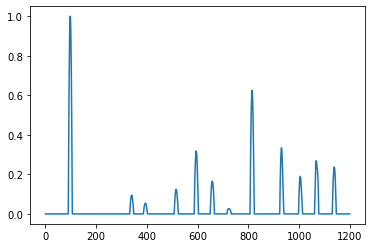

In [29]:
#model.predict(X_exp[1,:,:])
plt.plot(X_exp[53,:,:])
plt.show()

In [76]:
model.summary()

Model: "conv_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               multiple                  288       
_________________________________________________________________
conv2 (Conv1D)               multiple                  6208      
_________________________________________________________________
conv3 (Conv1D)               multiple                  24704     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
d1 (Dense)                   multiple                  39157888  
_________________________________________________________________
output (Dense)               multiple                  516       
Total params: 39,189,604
Trainable params: 39,189,604
Non-trainable params: 0
__________________________________________

In [81]:
model.evaluate(X_exp, Y_exp)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
print(X_th[:,:,:].shape)
print(X_th[1,:,0].shape)
print(X_th.shape)
model.predict(X_th[1,:,0])